# my_database_script_EONERC
Here I will create some basic plots for the data of EONERC. The idea of this notebook is to get an first overview of the data, which comes directly from the DTS device, without processesing.

In [1]:
#######Input###############
# change it to r".\\" if you are executing this notebook directly in the my_database folder
path_to_my_database = r"..\EONERC\Data" 
import_type = "pickle" # "csv" "pickle" - csv not implementent

plot_save = True    # True False
# some checks of the data, e.g. nan values
#check = False # True False - none implementet
############################

In [2]:
import pickle
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
plt.style.use("seaborn")
from collections import defaultdict
import glob
from collections import Counter
import matplotlib.patches as patches
import matplotlib.dates as mdates
from shutil import copy2 as copy_file
from matplotlib import colors
from datetime import date, timedelta

%load_ext autoreload
%autoreload 2

# import functions for importing data
from my_func_mvw.functions_import_my_database import import_my_database_pickle, import_my_database_csv, merge_data_year, import_complete_database
# import functions for measurements per day calculations
from my_func_mvw.functions_measurements_per_day import all_days_of_year, calculate_measurements_per_day, improve_n_meas_pday
# various other functions
from my_func_mvw.functions import get_abspath, read_pickle, calc_mean_channels_n_pday

print("Some Version information of the imported packages")
print(f"pandas: {pd.__version__}")
print(f"pickle: {pickle.format_version}")
!python --version

Some Version information of the imported packages
pandas: 1.3.5
pickle: 4.0
Python 3.8.12


In [3]:
# Load pickle data
if import_type == "pickle":
    # Load Data 2019+
    path_to_my_database_pickle = path_to_my_database + "\\unprocessed"

    data_2020=read_pickle(path_to_my_database_pickle + "\\data_from_charon3\\all_charon3_data_pickle")
    data_seperated_by_year=import_complete_database(path_to_my_database_pickle + "\\data_from_charon4\\pickle",importer=import_type,controller=3195)
    data_seperated_by_year["2020"]=data_2020

    #alternative
    data_2021=read_pickle(path_to_my_database + "\\data_all_charon4")

    # I should only keep this and delete the rest!
    # I could delete the files enterly then - not good, large file size should keep the channel and year wise save
    # ADAPT COMPLETE STRUCTURE OF EONERC SO ITS SIMILAR TO ALSDORF !!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!
    # then, calc data_2020 and data_2021 ... from data_all for code in the following cells
    data_all=read_pickle(path_to_my_database + "\\all_data")

# # # Merge the different years (2019+) dics into one
# data_all = merge_data_year([data_2020, data_2021])

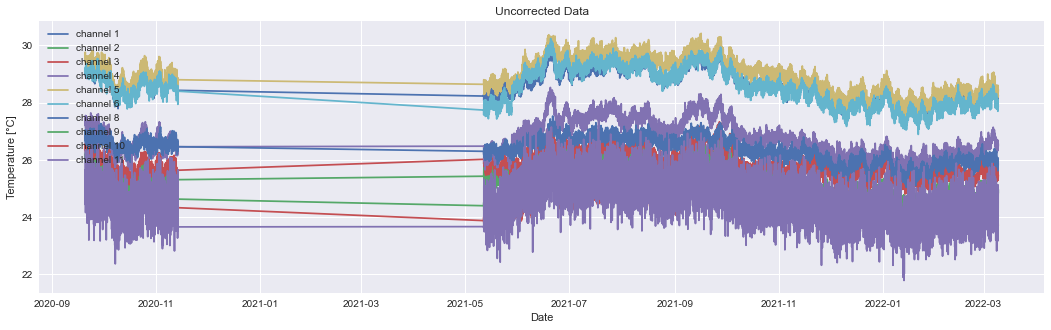

In [4]:
# Plot uncorrected data
length=10 # change me

channels=["1","2","3","4","5","6","8","9","10","11"]
plt.figure(figsize=(18,5))
for c in channels:
    inde=data_all[c][length].index
    val=data_all[c][length].values
    plt.plot(inde,val, label=f"channel {c}")
plt.xlabel("Date")
plt.ylabel("Temperature [°C]")
plt.title("Uncorrected Data")
plt.legend(loc="upper left") # with large amount of data loc="best" can be slow
plt.show()

# Measurements per day calculation

In [5]:
#count the number of measurements per day
n_meas_pday={}
for year in data_seperated_by_year.keys():
    print(year)
    n_meas_pday[year]=calculate_measurements_per_day(data_seperated_by_year[year],channels=channels)
    print()

# Improve n_meas_pdy: add days where 0 measurements were made
# days with 0 measurements will occur in the new dictionaries
n_meas_pday_with0={}
for year in data_seperated_by_year.keys():
    n_meas_pday_with0[year]=improve_n_meas_pday(n_meas_pday[year], int(year),channels=channels)

2021

2022

2020



In [6]:
# Calculate mean measurements per day per channel
mean_n_day={}; date_n_day={}
for year in data_seperated_by_year.keys():
    mean_n_day[year], date_n_day[year] = calc_mean_channels_n_pday(n_meas_pday_with0[year], channels=channels, check_dates_equal=False)

# Plot Measurements per day

In [7]:
def plot_save_func(filename_save):
    """saves the plots as png and copies them to my_database"""
    save_path = "pictures/" + filename_save + ".png"
    plt.savefig(save_path)
    # # copy pictures to my_database
    # save_to = r".\adapt_in_my_database_script_EONERC"
    # copy_file(save_path, save_to)

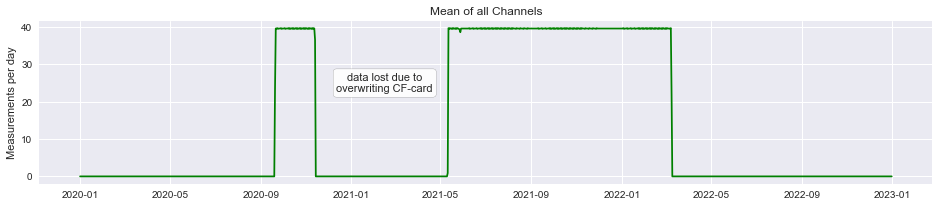

In [8]:
#Plot mean measurements per channel
plt.figure(figsize=[16,3])
# plt.plot(date_2019, mean_2019,color="green")
for year in data_seperated_by_year.keys():
    plt.plot(date_n_day[year], mean_n_day[year],color="green")
plt.ylabel("Measurements per day")
plt.title(f"Mean of all Channels")

# PLOT ACCESSOIREs
## some generel settings
bbox_props = dict(boxstyle="round", fc="w", ec="0.5", alpha=0.9)
size=11; y=25; ha="center"; va="center"

x=mdates.date2num(pd.to_datetime("15.02.2021"))
plt.text(x, y,"data lost due to\noverwriting CF-card", ha=ha, va=va, size=size, bbox=bbox_props) # data lost box

# Add txt for dates of data gaps

if plot_save:
    plot_save_func("EONERC_mean_of_all_channels_measpday")

plt.show()

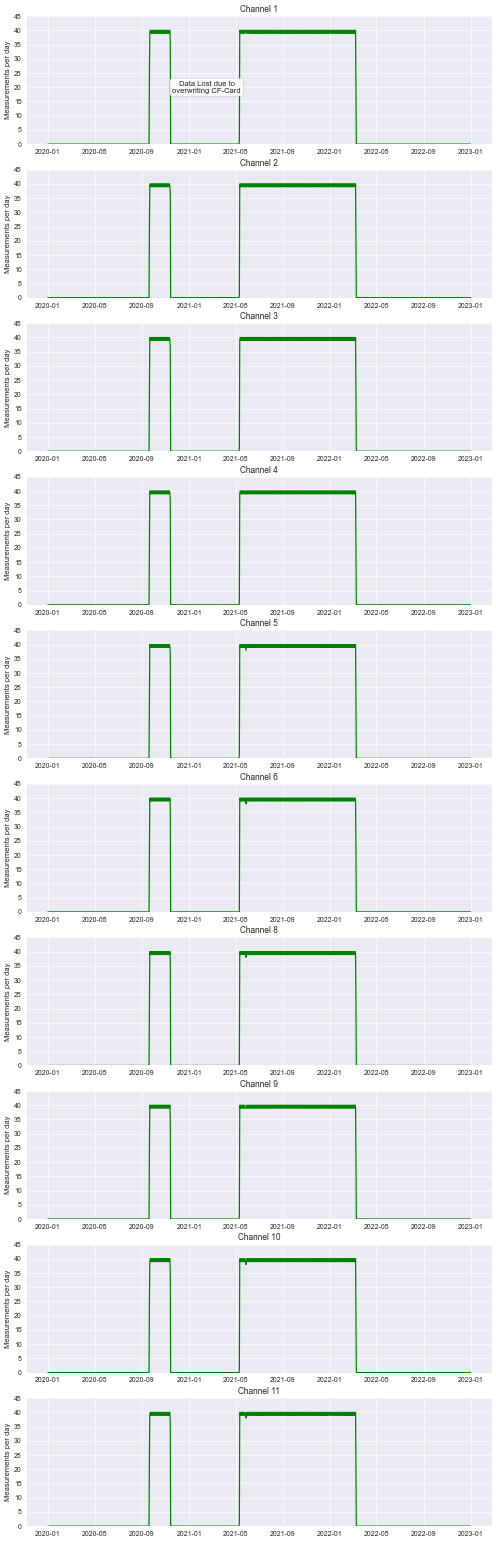

In [9]:
# Plot each channel seperate
fig,axs=plt.subplots(len(channels),1,figsize=[12,4*len(channels)], dpi=50)
counter=0
for channel in channels:
    n=counter
    c="green"
    for year in data_seperated_by_year.keys():
        axs[n].plot(pd.to_datetime(list(n_meas_pday_with0[year][channel])), n_meas_pday_with0[year][channel].values(),color=c)

    axs[n].set_ylabel("Measurements per day")
    #axs[n].set_xlabel("Date")
    axs[n].set_title(f"Channel {channel}")
    axs[n].set_ylim([0,45])

    counter+=1

# PLOT ACCESSOIREs
## some generel settings
bbox_props = dict(boxstyle="round", fc="w", ec="0.5", alpha=0.9)
size=11; y=20; ha="center"; va="center"

x=mdates.date2num(pd.to_datetime("15.02.2021"))
axs[0].text(x, y,"Data Lost due to\noverwriting CF-Card", ha=ha, va=va, size=size, bbox=bbox_props) # data lost box

if plot_save:
    plot_save_func("EONERC_all_channels_measpday")
plt.show()